### Tutorial
A simple tutorial for using the gravity simulator API. This file also serves as documentation.

### Import libraries
First, we import some libraries. If the path is wrong, please correct it manually.

In [1]:
import os
import sys
from pathlib import Path

parent_path = str(Path.cwd().parent)
sys.path.append(parent_path)
print(f"Appended path: \"{parent_path}\"")

import numpy as np

from gravity_sim import GravitySimulatorAPI

grav_sim = GravitySimulatorAPI()

print()
print(grav_sim.BUILT_IN_SYSTEMS)
print(grav_sim.AVAILABLE_INTEGRATORS)
print(grav_sim.AVAILABLE_ACCELERATION_METHODS)
print(grav_sim.AVAILABLE_STORING_METHODS)

Appended path: "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator"

dict_keys(['circular_binary_orbit', 'eccentric_binary_orbit', '3d_helix', 'sun_earth_moon', 'figure-8', 'pyth-3-body', 'solar_system', 'solar_system_plus'])
['euler', 'euler_cromer', 'rk4', 'leapfrog', 'rkf45', 'dopri', 'dverk', 'rkf78', 'ias15', 'whfast']
['pairwise', 'massless', 'barnes_hut']
['default', 'flush', 'disabled']


### Load pre-defined system

In [2]:
system = grav_sim.create_system()
system.load("solar_system")

### Adding new objects
Note that the default units are solar masses, AU and days

In [3]:
x = np.array([-8.092549658731499e-02, 2.558381434460076e00, -6.695836142398572e-02])
v = np.array(
    [
        -1.017876585480054e-02,
        -5.452367109338154e-04,
        1.255870551153315e-03,
    ]
)
m = 1.30268459e-10
system.add(x, v, m)

system.add_keplerian(
    semi_major_axis=4.2,
    eccentricity=0.1,
    inclination=0.1,
    longitude_of_ascending_node=1.0,
    argument_of_periapsis=1.0,
    true_anomaly=1.0,
    m=1.5e-9,
    primary_object_index=0,
)

system.center_of_mass_correction()

### Save system

In [4]:
system.save(Path(os.getcwd()) / "customized_systems.csv")

# You can also load customized system from csv files
# system.load("solar_system", Path(os.getcwd()) / "customized_systems.csv")

System "solar_system" successfully saved to "/Users/alvinng/Desktop/cuhk/gravity-simulator/Final Project/gravity-simulator/examples/customized_systems.csv"


### Plotting initial conditions

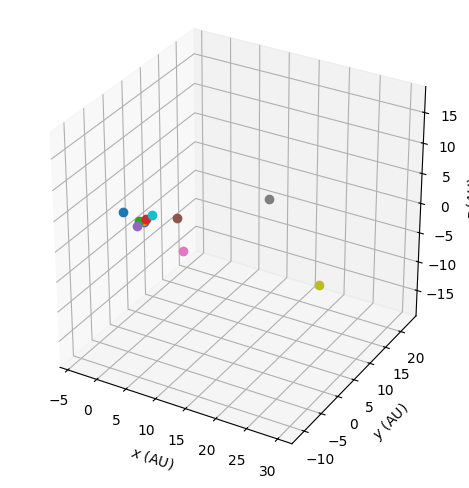

In [5]:
system.plot_3d_system()

### Launching simulation

In [6]:
integrator_params = {
    "integrator": "leapfrog",
    "dt" : grav_sim.years_to_days(0.001),
}
storing_params = {
    "method": "default",
    "storing_freq": 500,
}
sol_state, sol_time, sol_dt = grav_sim.launch_simulation(
    tf=grav_sim.years_to_days(1000.0),
    gravitational_system=system,
    integrator_params=integrator_params,
    storing_params=storing_params,
)

Output()

Simulation in progress...


Simulation completed! Run time: 0.939 s



In [7]:
print(f"Data size = {len(sol_state)}")

Data size = 2001


### Plotting trajectories

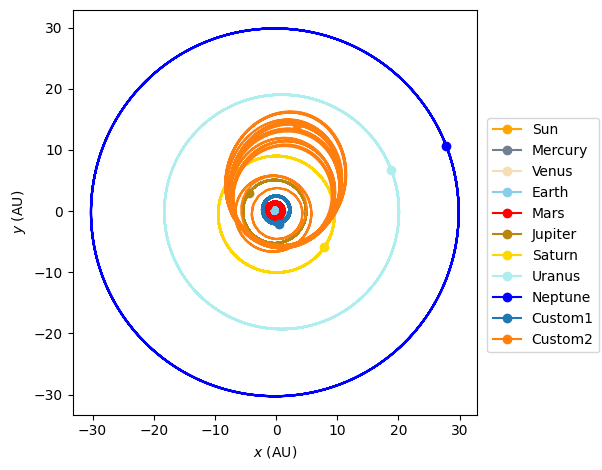

In [8]:
grav_sim.plot_2d_trajectory(
    sol_state,
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Custom1", "Custom2"],
    legend=True,
)

### More plots

Output()

Computing energy...


Run time: 0.120 s



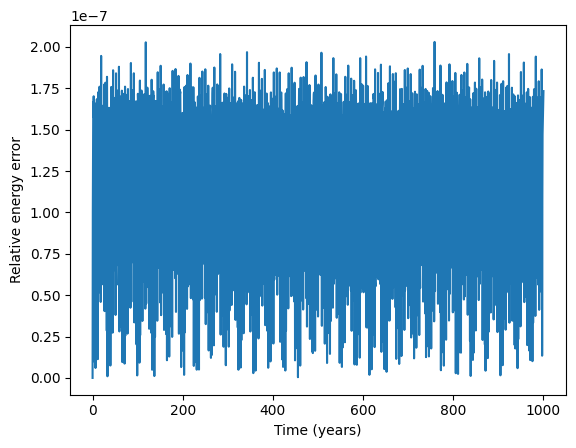

In [11]:
sol_energy = grav_sim.compute_energy(system, sol_state)
rel_energy_error = np.abs((sol_energy - sol_energy[0]) / sol_energy[0])
grav_sim.plot_quantity_against_time(
    quantity=rel_energy_error,
    sol_time=grav_sim.days_to_years(sol_time),
    xlabel="Time (years)",
    ylabel="Relative energy error",
)

Output()

Computing angular momentum...


Run time: 0.115 s



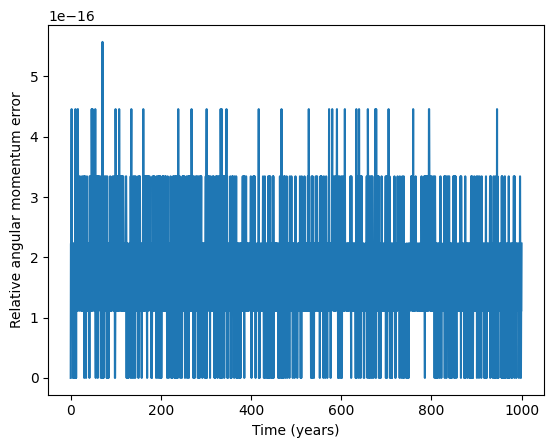

In [12]:
sol_angular_momentum = grav_sim.compute_angular_momentum(system, sol_state)
rel_angular_momentum_error = np.abs((sol_angular_momentum - sol_angular_momentum[0]) / sol_angular_momentum[0])
grav_sim.plot_quantity_against_time(
    quantity=rel_angular_momentum_error,
    sol_time=grav_sim.days_to_years(sol_time),
    xlabel="Time (years)",
    ylabel="Relative angular momentum error",
)

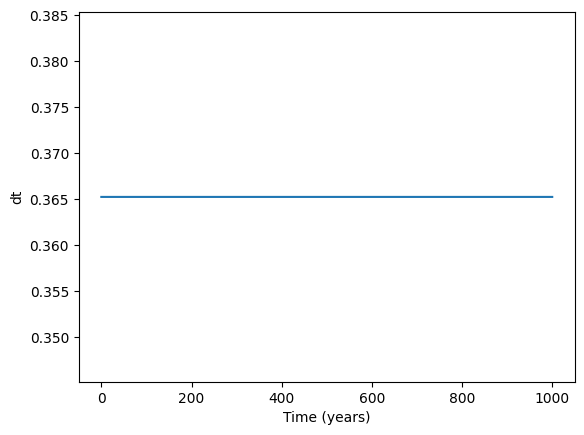

In [13]:
grav_sim.plot_quantity_against_time(
    quantity=sol_dt,
    sol_time=grav_sim.days_to_years(sol_time),
    xlabel="Time (years)",
    ylabel="dt",
)

### Animations

In [ ]:
grav_sim.animate_3d_traj_gif(
    file_path=Path(os.getcwd()) / "tutorial.gif",
    sol_state=sol_state,
    fps=30,
    dpi=200,
    plotting_freq=5,
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Custom1", "Custom2"],
    legend=True,
    traj_len=50,
)

Output()

### Save and reading results

In [ ]:
grav_sim.save_results()

# grav_sim.load_results(file_path="Your_file_path.csv")

### Splitting simulations into multiple sessions (Not available for WHFast)
After a simulation session, you can simply call `grav_sim.resume_simulation(simulation_time)` to launch a new session with the last saved state.
All the simulation parameters remains the same.
However, note that all the previous simulation history will be gone, so save them first before you resume the simulation.

*For WHFast, using `resume_simulation` would introduce error due to unknown bugs and is thus not recommended.

In [ ]:
grav_sim.resume_simulation(tf=grav_sim.years_to_days(2000.0))

grav_sim.plot_2d_trajectory(
    colors=[
        "orange",
        "slategrey",
        "wheat",
        "skyblue",
        "red",
        "darkgoldenrod",
        "gold",
        "paleturquoise",
        "blue",
        None,
        None,
    ],
    labels=system.objects_names,
    legend=True,
)

### Adaptive step size integrators

When using adaptive step size integrators, we provide tolerance rather than $\text{d}t$ to control the step size.
| Adaptive step size integrators | Recommended tolerance* |
|:-----------|:-------------|
| Runge–Kutta–Fehlberg 4(5) | $10^{-8}$ to $10^{-14}$ |
| Dormand–Prince method (DOPRI) 5(4) | $10^{-8}$ to $10^{-14}$ |
| Verner's method (DVERK) 6(5) | $10^{-8}$ to $10^{-14}$ |
| Runge–Kutta–Fehlberg 7(8) | $10^{-4}$ to $10^{-8}$ |
| IAS15 | $10^{-9}$ |

*For reference only

Using pyth-3-body, a highly chaotic system, we can easily see the difference between adaptive step size integrators and fixed step size integrators.

For RK4, the largest $\text{d}t$ we can use for this system is 2e-8.

In [ ]:
IAS15_system = grav_sim.create_system()
grav_sim.set_current_system(IAS15_system)
IAS15_system.load("pyth-3-body")

print("IAS15:")
grav_sim.launch_simulation(
    integrator="IAS15",
    tf=70.0,
    tolerance=1e-9,
)

grav_sim.plot_2d_trajectory()
grav_sim.plot_dt()

print("RK4:")
grav_sim.launch_simulation(
    integrator="rk4",
    tf=70.0,
    dt=1e-5,
    store_every_n=10000,
)

grav_sim.plot_2d_trajectory()
grav_sim.plot_dt()

### WHFast

When using WHFast, the order of adding objects matters. Since WHFast use Jacobi coordinate, we must first add the inner object. 

For convenience, you may also add the objects in any order, and then call `system.sort_by_distance(primary_object_name)` or `system.sort_by_distance(primary_object_index)`

In [ ]:
WHFast_system = grav_sim.create_system()
grav_sim.set_current_system(WHFast_system)
WHFast_system.load("solar_system")

# Shuffle the system for demonstration
indices = np.arange(WHFast_system.objects_count, dtype=int)
np.random.shuffle(indices)
WHFast_system.x = WHFast_system.x[indices]
WHFast_system.v = WHFast_system.v[indices]
WHFast_system.m = WHFast_system.m[indices]
WHFast_system.objects_names = list(np.array(WHFast_system.objects_names)[indices])

print(f"Shuffled: {WHFast_system.objects_names}")

WHFast_system.sort_by_distance(primary_object_name="Sun")

print(f"Sorted: {WHFast_system.objects_names}")

Simulating the solar system with WHFast

In [ ]:
grav_sim.launch_simulation(
    integrator="WHFast",
    tf=grav_sim.years_to_days(1000.0),
    dt=grav_sim.years_to_days(0.003),
    store_every_n=10,
)

colors = [
    grav_sim.SOLAR_SYSTEM_COLORS[objects_name]
    for objects_name in system.objects_names[:-2]
]
colors.extend([None, None])

grav_sim.plot_2d_trajectory(
    colors=colors,
    legend=True,
    labels=WHFast_system.objects_names,
)
grav_sim.plot_rel_energy()

You may run the following code block to see what happens when we don't sort the order by distance. Usually, the system would become much more unstable and also have a larger energy error. Sometimes, the program may even get stuck.

In [ ]:
WHFast_system = grav_sim.create_system()
grav_sim.set_current_system(WHFast_system)
WHFast_system.load("solar_system")

# Shuffle the system for demonstration
indices = np.arange(WHFast_system.objects_count, dtype=int)
np.random.shuffle(indices)
WHFast_system.x = WHFast_system.x[indices]
WHFast_system.v = WHFast_system.v[indices]
WHFast_system.m = WHFast_system.m[indices]
WHFast_system.objects_names = np.array(WHFast_system.objects_names)[indices]

print(WHFast_system.objects_names)

grav_sim.launch_simulation(
    integrator="WHFast",
    tf=grav_sim.years_to_days(300.0),
    dt=grav_sim.years_to_days(0.003),
    store_every_n=10,
)

grav_sim.plot_2d_trajectory(
    colors=[
        grav_sim.SOLAR_SYSTEM_COLORS[objects_name]
        for objects_name in WHFast_system.objects_names
    ],
    legend=True,
    labels=WHFast_system.objects_names,
)
grav_sim.plot_rel_energy()

# END
Here is the end of the tutorial. Check out other projects in the `examples` folder for more advanced usage.
* `solar_system_one_mil_yrs.ipynb`
* `asteroid_belt_animation.py`
* `kirkwood_gap.py`